# Figure - SSIM no constraint

Note: This notebook is adapted from `figure_iter_time_comparison.ipynb`


In [1]:
import os
work_dir = "H:/workspace/ptyrad_paper"
os.chdir(work_dir)
print("Current working dir: ", os.getcwd())

Current working dir:  H:\workspace\ptyrad_paper


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ptyrad.load import load_hdf5, load_pt
from ptyrad.utils.image_proc import center_crop
import h5py
from skimage.metrics import structural_similarity as ssim # This is not included in typical ptyrad environment
from scipy.ndimage import fourier_shift


In [3]:
import re

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(r'(\d+)', s)]

## Use SSIM with ground truth

In [4]:
gt_path = "00_data/simu_tBL_WSe2/phonon_temporal_spatial_N16384_dp128.hdf5"

# Reconstructions are done with nearly perfect initial positions (known from simulation) to minimize the effect of position correction
dir_ptyrad   = "03_output/simu_tBL_WSe2/20250219_ptyrad_convergence/full_N16384_dp128_flipT001_random16_p12_1obj_6slice_dz2_Adam_plr1e-4_oalr5e-4_oplr5e-4_slr1e-4_orblur0.4_ozblur1_oathr0.98_sng1.0_1e6/"
dir_ptyshv   = "03_output/simu_tBL_WSe2/20250219_ptyshv_convergence/6/roi6_Ndp128_step128/MLs_L1_p12_g16_pc1_noModel_mm_Ns6_dz2_reg0.1"
dir_py4dstem = "03_output/simu_tBL_WSe2/20250219_py4dstem_convergence/20250219_N16384_dp128_flipT001_random16_p12_6slice_dz2_update0.5_kzf0.1_1e6/"

# Get file names sorted
files_ptyrad = []
for file in os.listdir(dir_ptyrad):
    if file.startswith('model'):
        files_ptyrad.append(file)
files_ptyrad.sort()
print(f"Found {len(files_ptyrad)} ptyrad files")

files_ptyshv = []
for file in os.listdir(dir_ptyshv):
    if file.startswith('Niter'):
        files_ptyshv.append(file)
files_ptyshv = sorted(files_ptyshv, key=natural_sort_key)
print(f"Found {len(files_ptyshv)} ptyshv files")
        
files_py4dstem = []
for file in os.listdir(dir_py4dstem):
    if file.startswith('model'):
        files_py4dstem.append(file)
files_py4dstem.sort()
print(f"Found {len(files_py4dstem)} py4dstem files")

Found 38 ptyrad files
Found 38 ptyshv files
Found 38 py4dstem files


In [5]:
# Get ptyrad results
objs_ptyrad = []
for file in files_ptyrad:
    ckpt = load_pt(os.path.join(dir_ptyrad, file))
    obj = ckpt['optimizable_tensors']['objp'].detach().cpu().numpy().squeeze().sum(0)
    objs_ptyrad.append(obj)
iter_time_ptyrad = ckpt['avg_iter_t']

# Get ptyshv results
objs_ptyshv = []
for file in files_ptyshv:
    with h5py.File(os.path.join(dir_ptyshv, file), "r") as hdf_file:
        obj = np.angle(hdf_file['object'][()].view('complex128')).sum(0)
        obj = obj.T
        iter_time_ptyshv = hdf_file['outputs']['avgTimePerIter'][()].squeeze()[()]
        objs_ptyshv.append(obj)
        
# Get py4dstem results
objs_py4dstem = []
for file in files_py4dstem:
    with h5py.File(os.path.join(dir_py4dstem, file), "r") as hdf_file:
        obj = np.angle(hdf_file['object'][()].view('complex64')).sum(0)
        iter_time_py4dstem = hdf_file['iter_times'][()].mean(0)
        objs_py4dstem.append(obj)

Success! Loaded .pt file path = 03_output/simu_tBL_WSe2/20250219_ptyrad_convergence/full_N16384_dp128_flipT001_random16_p12_1obj_6slice_dz2_Adam_plr1e-4_oalr5e-4_oplr5e-4_slr1e-4_orblur0.4_ozblur1_oathr0.98_sng1.0_1e6/model_iter0001.pt
Success! Loaded .pt file path = 03_output/simu_tBL_WSe2/20250219_ptyrad_convergence/full_N16384_dp128_flipT001_random16_p12_1obj_6slice_dz2_Adam_plr1e-4_oalr5e-4_oplr5e-4_slr1e-4_orblur0.4_ozblur1_oathr0.98_sng1.0_1e6/model_iter0002.pt
Success! Loaded .pt file path = 03_output/simu_tBL_WSe2/20250219_ptyrad_convergence/full_N16384_dp128_flipT001_random16_p12_1obj_6slice_dz2_Adam_plr1e-4_oalr5e-4_oplr5e-4_slr1e-4_orblur0.4_ozblur1_oathr0.98_sng1.0_1e6/model_iter0003.pt
Success! Loaded .pt file path = 03_output/simu_tBL_WSe2/20250219_ptyrad_convergence/full_N16384_dp128_flipT001_random16_p12_1obj_6slice_dz2_Adam_plr1e-4_oalr5e-4_oplr5e-4_slr1e-4_orblur0.4_ozblur1_oathr0.98_sng1.0_1e6/model_iter0004.pt
Success! Loaded .pt file path = 03_output/simu_tBL_WSe2/

In [6]:
crop_height, crop_width = 170, 170 # Note that the window size and alignment would also impact the SSIM value
# The image shifts are obtained via SIFT registration using imageJ

# Get images
gt_phase = center_crop(load_hdf5(gt_path, key = 'gt_phase').sum(0), crop_height, crop_width, offset = [1,1])

ssims_ptyrad = []
for img_ptyrad in objs_ptyrad:
    img_ptyrad = center_crop(img_ptyrad, crop_height, crop_width, offset = [0,0])
    shift = [-0.205,-0.2675] # Check this
    img_ptyrad = np.real(np.fft.ifftn(fourier_shift(np.fft.fftn(img_ptyrad), shift)))
    img_ptyrad -= img_ptyrad.min()
    
    ssim_ptyrad = ssim(img_ptyrad, gt_phase, data_range=(gt_phase.max() - gt_phase.min()))
    print(ssim_ptyrad)
    ssims_ptyrad.append(ssim_ptyrad)
    
ssims_ptyshv = []
for img_ptyshv in objs_ptyshv:
    img_ptyshv = center_crop(img_ptyshv, crop_height, crop_width, offset = [-1,-1])
    shift = [-0.35,-0.416]
    img_ptyshv = np.real(np.fft.ifftn(fourier_shift(np.fft.fftn(img_ptyshv), shift)))
    img_ptyshv -= img_ptyshv.min()
    
    ssim_ptyshv = ssim(img_ptyshv, gt_phase, data_range=(gt_phase.max() - gt_phase.min()))
    ssims_ptyshv.append(ssim_ptyshv)
        
ssims_py4dstem = []
for img_py4dstem in objs_py4dstem:
    img_py4dstem = center_crop(img_py4dstem, crop_height, crop_width, offset = [1,1])
    shift = [0.32, 0.22]
    img_py4dstem = np.real(np.fft.ifftn(fourier_shift(np.fft.fftn(img_py4dstem), shift)))
    img_py4dstem -= img_py4dstem.min()
    
    ssim_py4dstem = ssim(img_py4dstem, gt_phase, data_range=(gt_phase.max() - gt_phase.min()))
    ssims_py4dstem.append(ssim_py4dstem)

Success! Loaded .hdf5 file with key = 'gt_phase' from path = '00_data/simu_tBL_WSe2/phonon_temporal_spatial_N16384_dp128.hdf5'
Imported .hdf5 data shape = (15, 369, 368)
Imported .hdf5 data type = float32
0.5442589383518599
0.6249763296046148
0.6605308000984502
0.7075723699443064
0.7425911531909405
0.77378758062885
0.8073223883974222
0.8179775941064321
0.8294706568520811
0.8396245323338727
0.8467808154249283
0.8527136016603846
0.8556365066366952
0.8585024829300155
0.8618282116705785
0.8650697832954809
0.8683117919561056
0.8709978995327259
0.8728162500739168
0.8746614666397482
0.8788910847952826
0.8918474263255083
0.901098842515983
0.9075499485550999
0.9115871938564889
0.9123958242810035
0.9123936342912051
0.9141614547000443
0.9146346366681172
0.9146349494152131
0.9127842596577506
0.9100174040736931
0.9090318027163531
0.9096857514021867
0.9111072988443826
0.9116704560226802
0.9105662071167678
0.9095984394664852


In [7]:
# from tifffile import imwrite
# imwrite('ptyrad.tif', np.float32(objs_ptyrad))
# imwrite('ptyshv.tif', np.float32(objs_ptyshv))
# imwrite('py4dstem.tif', np.float32(objs_py4dstem))
# imwrite('stack.tif', np.stack([np.float32(gt_phase), np.float32(img_ptyrad), np.float32(img_ptyshv), np.float32(img_py4dstem)]).astype('float32'))

PtyRAD (min,mean,max) = (0.0, 0.309, 2.754)
PtyShv (min,mean,max) = (0.0, 0.346, 2.551)
py4DSTEM (min,mean,max) = (0.0, 0.461, 3.623)
Ground Truth (min,mean,max) = (0.043, 0.275, 3.433)


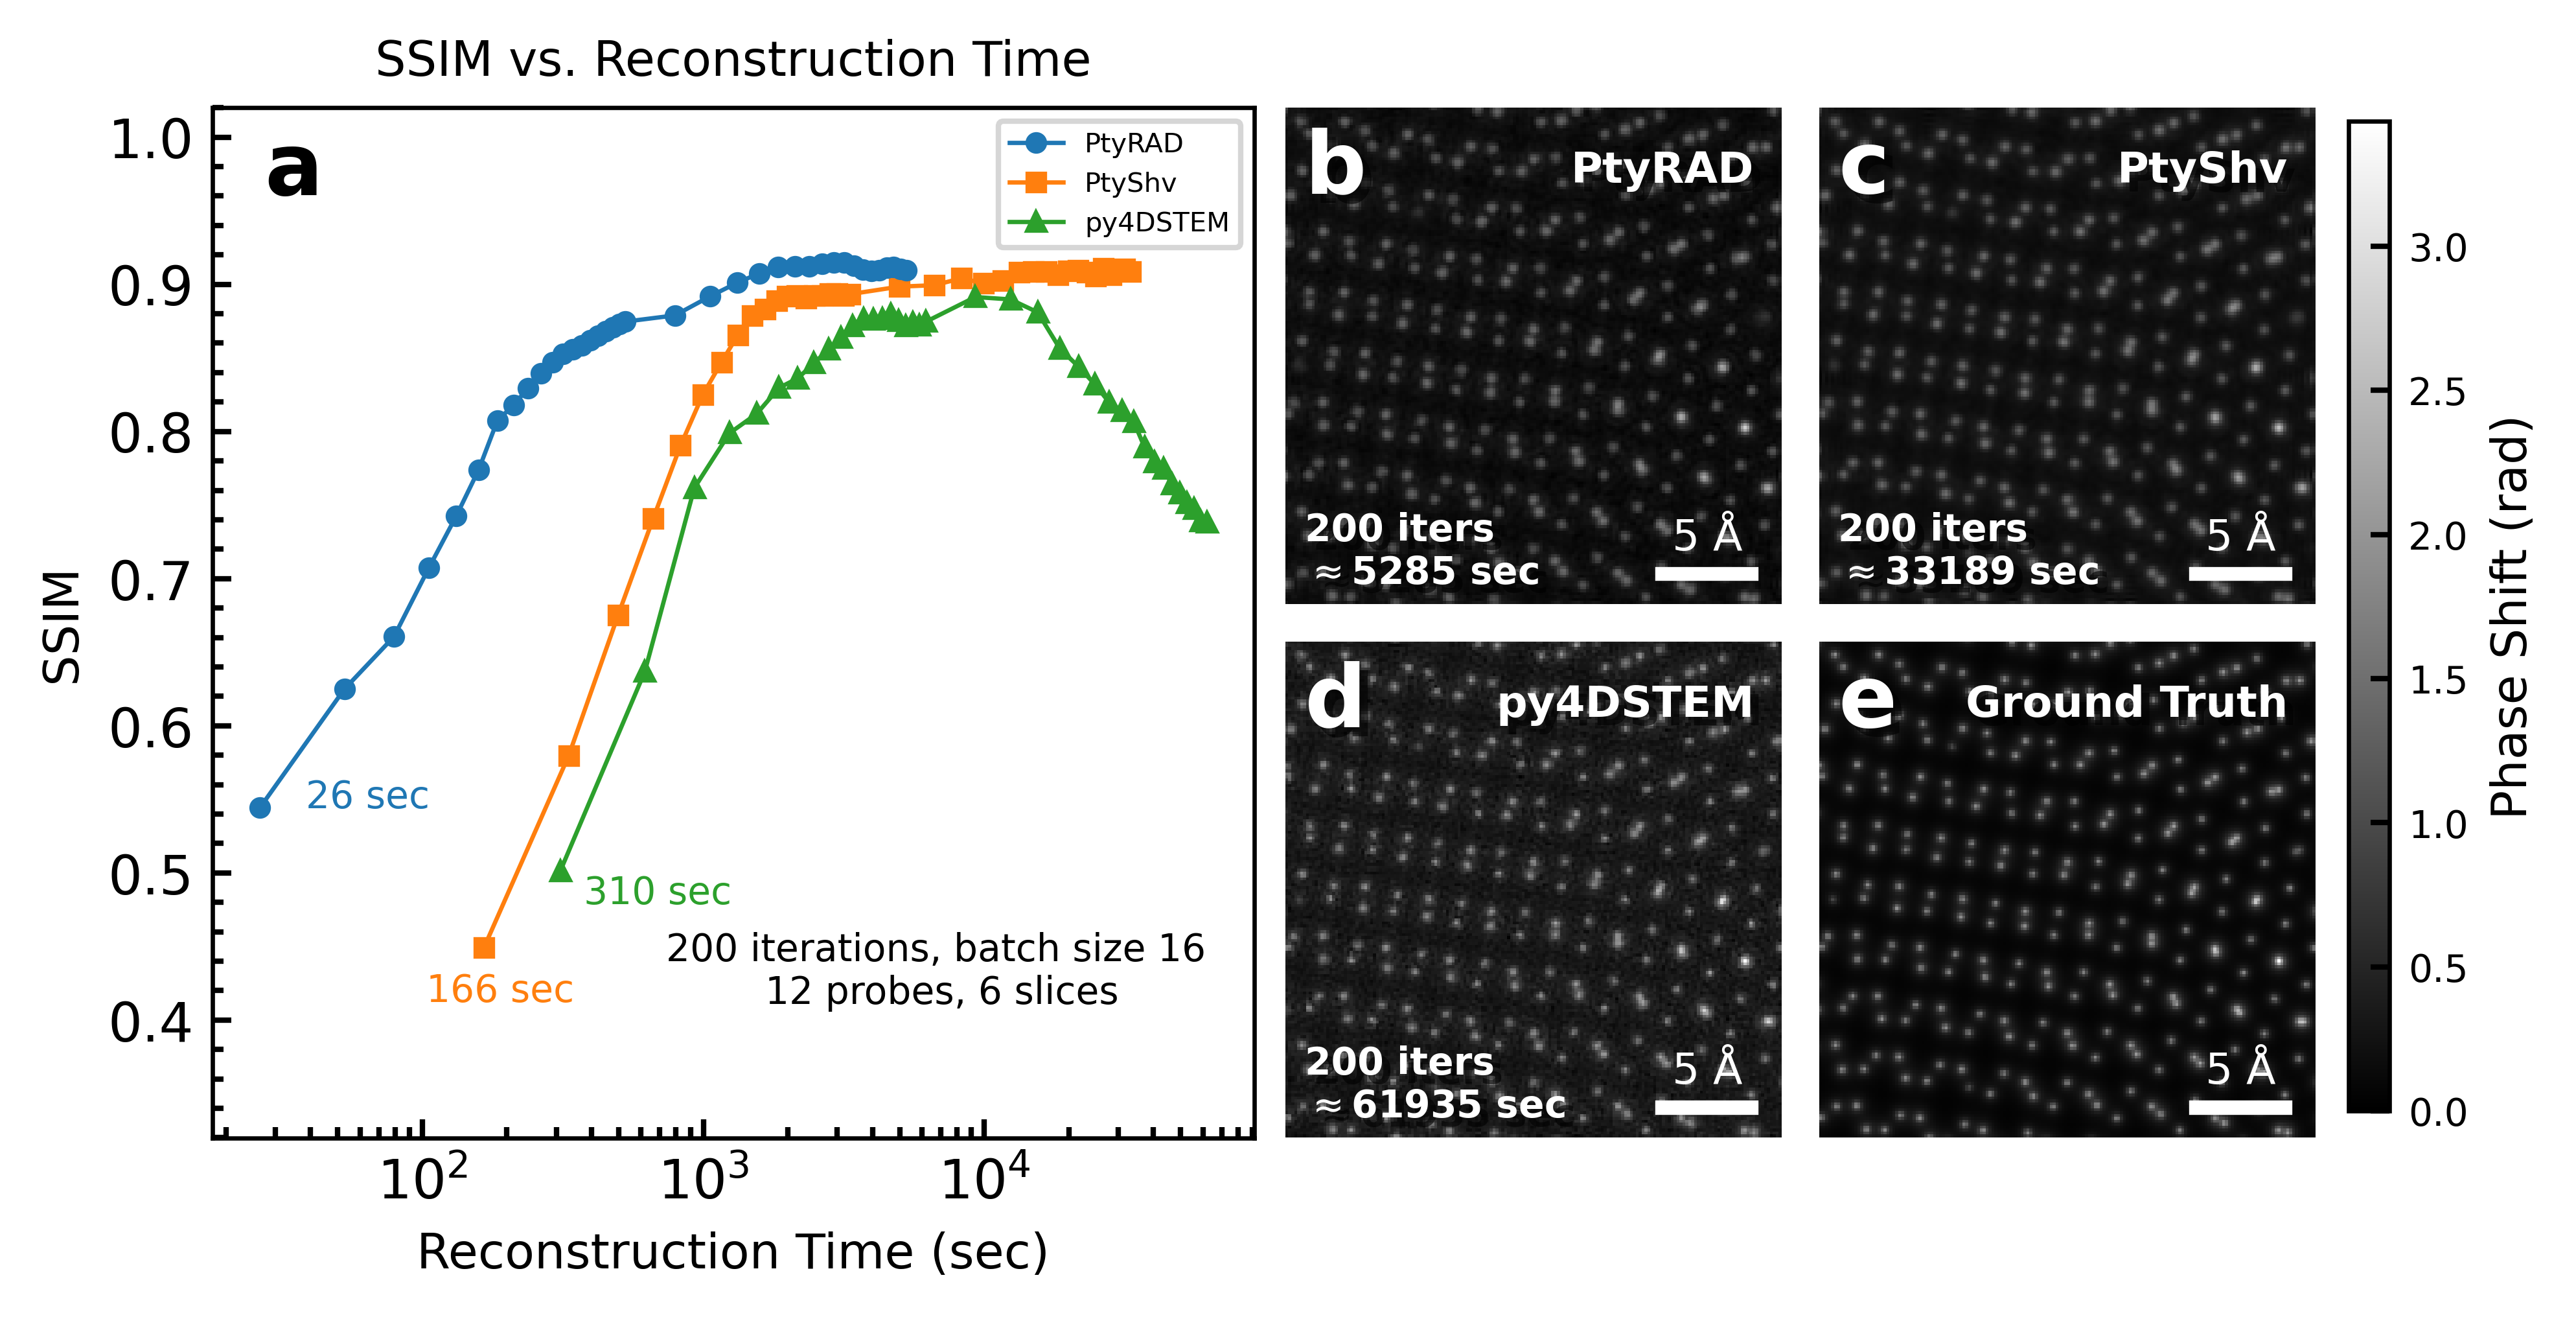

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.ticker as tck
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rc('xtick', direction='in')
mpl.rc('xtick.major', width=1, size=3.5)
mpl.rc('xtick.minor', width=1, size=2)
mpl.rc('ytick', direction='in')
mpl.rc('ytick.major', width=1, size=3.5)
mpl.rc('ytick.minor', width=1, size=2)

# Plot Data
# Note that these data are all computed on 20GB slice

imgs = np.reshape([img_ptyrad, img_ptyshv, img_py4dstem, gt_phase], (2,2,crop_height, crop_width))
packages = np.reshape(['PtyRAD', 'PtyShv', 'py4DSTEM', 'Ground Truth'], (2,2))
panels = np.reshape(['b', 'c', 'd', 'e'], (2,2))
iterations = np.array([i for i in range(1,20)] + [i for i in range(20,210,10)])
vmin = 0
vmax = gt_phase.max()
iter_value = 200

iters = np.reshape([f'{iter_value} iters\n'+r'$\approx$'+f'{np.int32(iter_time_ptyrad*iter_value)} sec', 
        f'{iter_value} iters\n'+r'$\approx$'+f'{np.int32(iter_time_ptyshv*iter_value)} sec', 
        f'{iter_value} iters\n'+r'$\approx$'+f'{np.int32(iter_time_py4dstem*iter_value)} sec',
        ''], (2,2))

# Figure configuration
figsize=(7,3.44)
dpi = 600 #600
shadow_offset = (3,3)
iters_loc = (6,165)

# Global font/line control
linewidth = 0.8
markersize = 3
fontsize_title = 9
fontsize_subtitle = 7
fontsize_label = 9
fontsize_legend = 5
fontsize_panel = 16
fontsize_package = 8
fontsize_time = 7
annotate_size = 7

# Scale bar settings
scale_bar_length = 5/0.1494
scale_bar_label = "5 $\\mathrm{\\AA}$"
fontprops = fm.FontProperties(size=8)

# Create figure
fig = plt.figure(figsize=figsize, dpi=dpi)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.075, wspace=0.05)

# Panel 1: Error vs. Iteration
ax_SSIM = fig.add_subplot(gs[:, :2])

ax_SSIM.plot(iterations[:len(ssims_ptyrad)]  *iter_time_ptyrad, ssims_ptyrad, label='PtyRAD', marker='o', linewidth=linewidth, markersize=markersize, zorder=10)
ax_SSIM.plot(iterations[:len(ssims_ptyshv)]  *iter_time_ptyshv, ssims_ptyshv, label='PtyShv', marker='s', linewidth=linewidth, markersize=markersize)
ax_SSIM.plot(iterations[:len(ssims_py4dstem)]*iter_time_py4dstem, ssims_py4dstem, label='py4DSTEM', marker='^', linewidth=linewidth, markersize=markersize)

ax_SSIM.set_title('SSIM vs. Reconstruction Time', fontsize=fontsize_title)
ax_SSIM.text(0.70, 0.20, '200 iterations, batch size 16 \n12 probes, 6 slices', 
             transform=ax_SSIM.transAxes, ha='center', va='top', fontsize=fontsize_subtitle, color='k')
ax_SSIM.set_xlabel('Reconstruction Time (sec)', fontsize=fontsize_label)
ax_SSIM.set_ylabel('SSIM', fontsize=fontsize_label)
ax_SSIM.text(0.05,0.98, 'a', transform=ax_SSIM.transAxes, color='black', fontsize=fontsize_panel, fontweight='bold', va='top', ha='left')

ax_SSIM.annotate(f'{iter_time_ptyrad:.0f} sec', (iter_time_ptyrad, ssims_ptyrad[0]), textcoords="offset points", xytext=(20,0), ha='center', color='C0', fontsize=annotate_size)
ax_SSIM.annotate(f'{iter_time_ptyshv:.0f} sec', (iter_time_ptyshv, ssims_ptyshv[0]), textcoords="offset points", xytext=(3,-10), ha='center', color='C1', fontsize=annotate_size)
ax_SSIM.annotate(f'{iter_time_py4dstem:.0f} sec', (iter_time_py4dstem, ssims_py4dstem[0]), textcoords="offset points", xytext=(18,-6), ha='center', color='C2', fontsize=annotate_size)

ax_SSIM.legend(fontsize=fontsize_legend, loc='upper right')
ax_SSIM.set_xscale('log')
ax_SSIM.set_ylim(0.32,1.02)
ax_SSIM.yaxis.set_minor_locator(tck.AutoMinorLocator())

# Panel 2 - 5: Objects from packages and ground truth
for i in range(2):
    for j in range(2):
        print(f"{packages[i,j]} (min,mean,max) = {imgs[i,j].min().round(3).item(), imgs[i,j].mean().round(3).item(), imgs[i,j].max().round(3).item()}")
        ax = fig.add_subplot(gs[i, j+2])
        ax.imshow(imgs[i,j], cmap='gray', vmin=vmin, vmax=vmax)
        ax.axis('off')
        
        # Add panel label with text shadow
        ax.text(6 + shadow_offset[0], 6 + shadow_offset[1], panels[i, j], color='black', fontsize=fontsize_panel, fontweight='bold', va='top', ha='left', alpha=0.6)
        ax.text(6, 6, panels[i, j], color='white', fontsize=fontsize_panel, fontweight='bold', va='top', ha='left')
        
        # Add package label with text shadow
        ax.text(crop_width-10 + shadow_offset[0], 14 + shadow_offset[1], packages[i, j], color='black', fontsize=fontsize_package, fontweight='bold', va='top', ha='right', alpha=0.6)
        ax.text(crop_width-10, 14, packages[i, j], color='white', fontsize=fontsize_package, fontweight='bold', va='top', ha='right')
        
        # Add iter time label with text shadow
        ax.text(iters_loc[0] + shadow_offset[0], iters_loc[1] + shadow_offset[1], iters[i,j], color='black', fontsize=fontsize_time, fontweight='bold', va='bottom', ha='left', alpha=0.6)
        ax.text(iters_loc[0], 
                iters_loc[1], iters[i,j], color='white', fontsize=fontsize_time, fontweight='bold', ha='left', va='bottom')
        
        # Scale bar
        scalebar = AnchoredSizeBar(ax.transData, scale_bar_length, scale_bar_label,
                                loc='lower right', pad=0.5, color="white", frameon=False, size_vertical=3, label_top=True,
                                fontproperties=fontprops)
        ax.add_artist(scalebar)
        
# Add common colorbar on the right
cax_base = ax.imshow(imgs[-1,-1], cmap='gray', vmin=vmin, vmax=vmax) # Use the gt image to base the colorbar on
cax = fig.add_axes([0.91, 0.13, 0.015, 0.74])  # [left, bottom, width, height]
cbar = fig.colorbar(cax_base, cax=cax)
cbar.ax.tick_params(labelsize=7)
cbar.set_label("Phase Shift (rad)", fontsize=fontsize_label)

fig_name = 'Fig_SXX_SSIM_no_constraint'
plt.savefig(f"05_figures/{fig_name}.pdf", bbox_inches="tight")

plt.show()